## Getis ord con Pysal

### 1. Preparar los datos
Asumiendo que tienes una tabla df con las siguientes columnas:
- postal_code: Código postal.
- positivity_rate: Tasa de positividad ajustada por la población de mascotas. Para conseguir este número, hay que sumar todos los casos positivos y strong positive de un mismo CP y luego dividir por la estimación de la población de mascotas de ese CP (esto es una posible normalización)
- geometry: Geometría de los códigos postales en formato de polígonos (esto se puede obtener con geopandas).


In [1]:
# imports
import pandas as pd

import geopandas as gpd
from libpysal.weights import DistanceBand

from esda import G_Local
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
df = pd.read_csv("data/new_data.csv", dtype={'Postal code': str})

# fitler to get two columns
df = df[['Value test', 'Postal code']]

# change postal codes with 4 digits to 5 addin a 0 in the left
df['Postal code'] = df['Postal code'].str.zfill(5)

print(df.head(1))

  Value test Postal code
0   Negativo       08520


In [14]:
# load postal codes shapefile to get polygon
gdf_postal_info = gpd.read_file("data/codigos_postales/codigos_postales.shp")
gdf_postal_info = gdf_postal_info.rename(columns={'COD_POSTAL': 'Postal code'})
gdf_postal_info = gdf_postal_info[['Postal code', 'geometry']]
print(gdf_postal_info.head(1))
print(gdf_postal_info.crs)

  Postal code                                           geometry
0       01193  POLYGON ((-2.5306 42.81828, -2.53061 42.81814,...
None


In [23]:
# Contar el número total de resultados y positivos por código postal
positive_rate_df = (
    df.assign(is_positive = lambda x: x['Value test'] == 'Positivo')  # Crear una columna booleana
    .groupby('Postal code')  # Agrupar por código postal
    .agg(total_cases = ('Value test', 'size'),  # Total de casos
         positive_cases = ('is_positive', 'sum'))  # Total de casos positivos
    .assign(positivity_rate = lambda x: x['positive_cases'] / x['total_cases'] * 100)  # Calcular porcentaje
)

# Mostrar el resultado
print(positive_rate_df)

             total_cases  positive_cases  positivity_rate
Postal code                                              
01002                 31               5        16.129032
01004                  2               1        50.000000
01006                 19               3        15.789474
01012                  3               1        33.333333
01013                  2               0         0.000000
...                  ...             ...              ...
50781                  3               0         0.000000
50800                 12               1         8.333333
50830                115              12        10.434783
52005                  2               2       100.000000
52006                  3               2        66.666667

[1234 rows x 3 columns]


In [24]:
# merge both dataframes to work with df
df_merged = pd.merge(positive_rate_df, gdf_postal_info, on='Postal code', how='left')

print(df_merged.head())

  Postal code  total_cases  positive_cases  positivity_rate  \
0       01002           31               5        16.129032   
1       01004            2               1        50.000000   
2       01006           19               3        15.789474   
3       01012            3               1        33.333333   
4       01013            2               0         0.000000   

                                            geometry  
0  POLYGON ((-2.64286 42.85681, -2.64281 42.85679...  
1  POLYGON ((-2.6641 42.84083, -2.66666 42.84074,...  
2  POLYGON ((-2.64069 42.84237, -2.64105 42.84122...  
3  POLYGON ((-2.67257 42.85386, -2.67258 42.85385...  
4  POLYGON ((-2.6658 42.89038, -2.66578 42.89036,...  


### 2. Crear la Matriz de Ponderación Espacial
Para crear una matriz de ponderación espacial, puedes definir los vecinos por distancia usando un umbral específico (por ejemplo, 5 km). PySAL proporciona métodos para generar esta matriz de adyacencia.

In [34]:
# Cargar los datos en un GeoDataFrame
gdf = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")
gdf = gdf.to_crs("EPSG:25830")

gdf = gdf[gdf.is_valid]

# Crear la matriz de ponderación basada en una distancia de 5 km (ajustable)
w = DistanceBand.from_dataframe(gdf, threshold=5000, binary=True)
w.transform = 'r' # normalize

('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 28, ' is an island (no neighbors)')
('WARNING: ', 37, ' is an island (no neighbors)')
('WARNING: ', 39, ' is an island (no neighbors)')
('WARNING: ', 42, ' is an island (no neighbors)')
('WARNING: ', 44, ' is an island (no neighbors)')
('WARNING: ', 45, ' is an island (no neighbors)')
('WARNING: ', 50, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 52, ' is an island (no neighbors)')
('WARNING: ', 53, ' is an island (no neighbors)')
('WARNING: ', 54, ' is an island (no neighbors)')
('WA

c:\Users\alexg\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 695 disconnected components.
 There are 538 islands with ids: 5, 6, 7, 8, 11, 12, 13, 14, 24, 28, 37, 39, 42, 44, 45, 50, 51, 52, 53, 54, 57, 64, 65, 66, 67, 68, 72, 74, 89, 90, 91, 93, 101, 103, 105, 108, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 140, 143, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 161, 162, 163, 164, 165, 168, 174, 175, 176, 179, 180, 213, 218, 228, 235, 236, 241, 246, 249, 259, 261, 270, 273, 281, 285, 288, 299, 321, 322, 323, 326, 327, 328, 329, 330, 331, 332, 339, 340, 341, 342, 343, 344, 348, 351, 352, 358, 359, 362, 363, 364, 365, 366, 370, 371, 373, 374, 377, 378, 379, 383, 384, 385, 386, 387, 388, 393, 394, 395, 396, 397, 398, 399, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416

In [35]:
print("Número de observaciones en el GeoDataFrame:", len(gdf))
print("Número de elementos en la matriz de ponderación:", len(w.data))

Número de observaciones en el GeoDataFrame: 1535
Número de elementos en la matriz de ponderación: 1535


### 3. Calcular el Estadístico Getis-Ord Gi*
Una vez que tienes la matriz de ponderación (w) y la variable positivity_rate, puedes usar esda.G de PySAL para calcular el estadístico.

In [36]:
# Calculate Getis-Ord Gi*
g = G_Local(gdf['positivity_rate'], w)

# Obtain z-values y p-values
z_values = g.Zs  # Array with z-value
p_values = g.p_sim  # Array with p-value

c:\Users\alexg\AppData\Local\Programs\Python\Python312\Lib\site-packages\esda\getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
c:\Users\alexg\AppData\Local\Programs\Python\Python312\Lib\site-packages\esda\getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


### 4. Interpretación de Resultados

Los arrays z_values y p_values ahora contienen el valor Z y el valor p para cada código postal en el orden de los datos originales:
- Los valores Z positivos significativos (por ejemplo, con ) indican puntos calientes.
- Los valores Z negativos significativos (también con ) indican puntos fríos.

In [37]:
# Agregar los resultados al GeoDataFrame
gdf['z_value'] = z_values
gdf['p_value'] = p_values

### 5. Visualizacion
Con los resultados en el GeoDataFrame, puedes crear un mapa de coropletas para visualizar los puntos calientes y fríos.

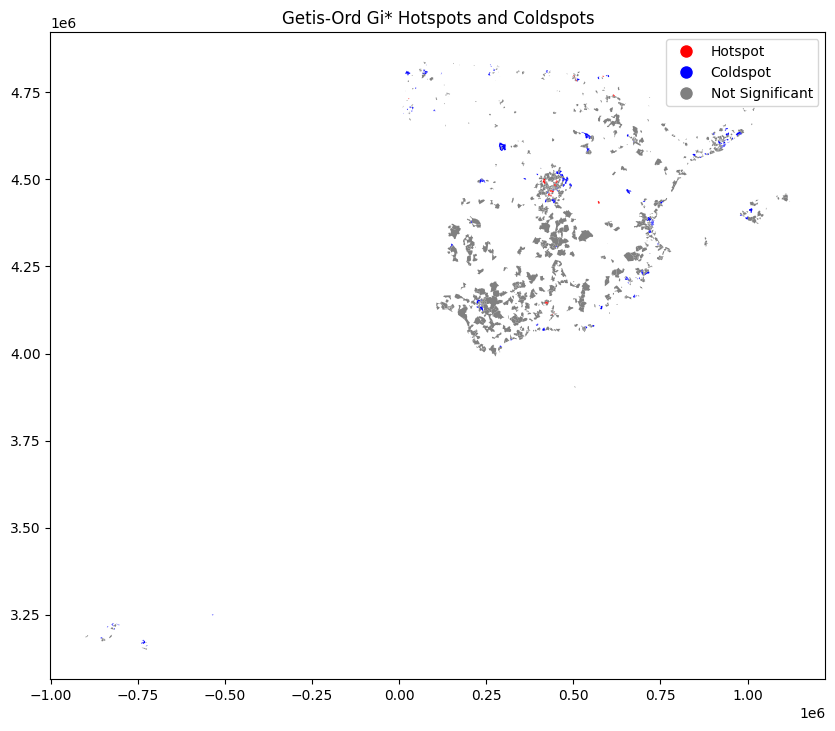

In [42]:
# Filtrar puntos calientes y fríos significativos
gdf['hotspot'] = np.where((gdf['z_value'] > 0) & (gdf['p_value'] < 0.05), 'Hotspot',
                          np.where((gdf['z_value'] < 0) & (gdf['p_value'] < 0.05), 'Coldspot', 'Not Significant'))

# Crear un mapeo de colores personalizado
colors = ['red', 'blue', 'gray']  # Hotspot: rojo, Coldspot: azul, Not Significant: gris
cmap = ListedColormap(colors)

# Asignar un índice a cada categoría
hotspot_categories = {'Hotspot': 0, 'Coldspot': 1, 'Not Significant': 2}
gdf['hotspot_code'] = gdf['hotspot'].map(hotspot_categories)

# Visualización
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='hotspot_code', cmap=cmap, legend=False, ax=ax)

# Añadir una leyenda personalizada
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Hotspot'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Coldspot'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Not Significant')
]
ax.legend(handles=legend_elements, loc='upper right')

# Título del gráfico
plt.title("Getis-Ord Gi* Hotspots and Coldspots")
plt.show()